<a href="https://colab.research.google.com/github/kirwarobert/cnn/blob/main/DeepQLearning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install 'kaggle-environments>=0.1.6' > /dev/null 2>&1

In [10]:
import numpy as np
import gym
import random
import matplotlib.pyplot as plt
from random import choice
from tqdm.notebook import tqdm
from kaggle_environments import evaluate, make
import math

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 179, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 64, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

Loading environment lux_ai_s2 failed: cannot import name '_center' from 'numpy._core.umath' (/usr/local/lib/python3.11/dist-packages/numpy/_core/umath.py)
Loading environment llm_20_questions failed: Failed to import transformers.models.t5.modeling_t5 because of the following error (look up to see its traceback):
Failed to import transformers.generation.utils because of the following error (look up to see its traceback):
cannot import name '_center' from 'numpy._core.umath' (/usr/local/lib/python3.11/dist-packages/numpy/_core/umath.py)


In [11]:
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=True)
        self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob

        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)

    def reset(self):
        if random.uniform(0, 1) < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()

    def render(self, **kwargs):
        return self.env.render(**kwargs)

In [12]:
env = ConnectX()

In [13]:
import torch
from torch import optim
import torch.nn as nn
# if gpu is to be used
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")

In [14]:
seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [15]:
###### PARAMS ######
learning_rate = 0.01
num_episodes = 2000
gamma = 0.85

egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500

####################

In [16]:
env.observation_space.n , env.action_space.n

(42, 7)

In [17]:
number_of_inputs = env.observation_space.n + 1
number_of_outputs = env.action_space.n
hidden_layer = 64
number_of_inputs , number_of_outputs , hidden_layer

(43, 7, 64)

In [18]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [19]:
class NeauralNetwork(nn.Module):
    def __init__(self):
        super(NeauralNetwork , self).__init__()
        self.l1 = nn.Linear(number_of_inputs,hidden_layer)
        self.l2 = nn.Linear(hidden_layer,number_of_outputs)
        self.activation = nn.ReLU()

    def forward(self , x):
        output = self.activation(self.l1(x))
        output = self.l2(output)
        return output

In [27]:
class QAgent(object):
    def __init__(self):
        self.nn = NeauralNetwork()
        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters() , lr=learning_rate)

    def select_action(self,state,epsilon):
        random_for_egreedy = torch.rand(1)[0]

        if random_for_egreedy > epsilon:

            with torch.no_grad():

                state = torch.Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn,0)[1]
                action = action.item()
        else:
            action = env.action_space.sample()

        return action

    def optimize(self, state, action, new_state, reward, done):
        state = torch.Tensor(state).to(device)
        new_state = torch.Tensor(new_state).to(device)
        #print(reward)
        #print(action)
        reward = torch.Tensor([reward]).to(device)

        if done:
            target_value = reward
        else:
            new_state_values = self.nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values)
            target_value = reward + gamma * max_new_state_values
        #print(action)
        #print(self.nn(state))
        predicted_value = self.nn(state)[action]

        loss = self.loss_func(predicted_value , target_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [29]:
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=True)
        self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob

        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)

    def reset(self):
        if random.uniform(0, 1) < self.switch_prob:
            self.switch_trainer()
        obs = self.trainer.reset()
        # Return the observation in the expected format with 'board' and 'mark' attributes
        return Struct(board=obs.board, mark=obs.mark)

    def render(self, **kwargs):
        return self.env.render(**kwargs)

Average reward: 0.01
Average reward (last 100 episodes): 0.23


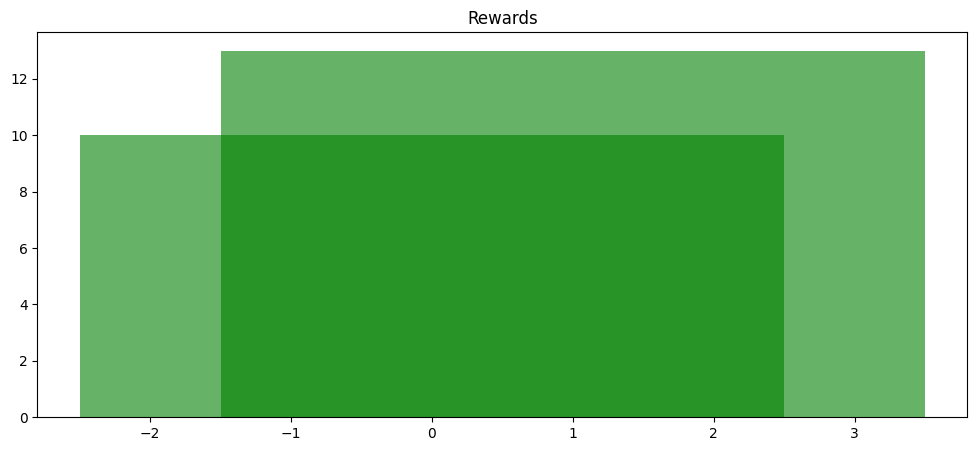

In [30]:
print("Average reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))

plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green', width=5)
plt.show()